# Dist-dip test illustration

In [75]:
from collections import Counter
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import umap
import diptest
from sklearn.decomposition import PCA
from sklearn import datasets
from scipy.fft import dct
from scipy.spatial.distance import pdist, squareform
from tslearn.metrics import cdist_dtw

import sys
sys.path.append('../')
from src.dataset import Dataset
from src.condition import Condition
from src.representations import contour_array
from src.preprocess.synthesize import MarkovSynthesizer, subsample_clustered_contours
from helpers import cm2inch, title, format_pval, get_pval_cmap
from matplotlib.colors import LogNorm

import warnings
warnings.filterwarnings("ignore", category=Warning)

## Dip dist test illustration

In [240]:
def show_bivariate_data(data, labels=None):
    fig, axs = plt.subplots(1, 3, figsize=(8, 3), tight_layout=True)
    for ax in axs[:2]:
        ax.set_yticks([])
        ax.set_xticks([])
        sns.despine(ax=ax)

    x, y = data.T
    axs[0].scatter(x, y, alpha=.2, c=labels)
    title('A. Data', ax=axs[0])
    
    distances = pdist(data, metric='euclidean')
    axs[1].imshow(squareform(distances))
    title('B. Distance matrix', ax=axs[1])
    
    sns.kdeplot(distances, fill=True, ax=axs[2]);
    title('C. Distance distribution', ax=axs[2])
    axs[2].set_xlabel('pairwise distance')
    axs[2].set_yticks([])
    sns.despine(ax=axs[2])

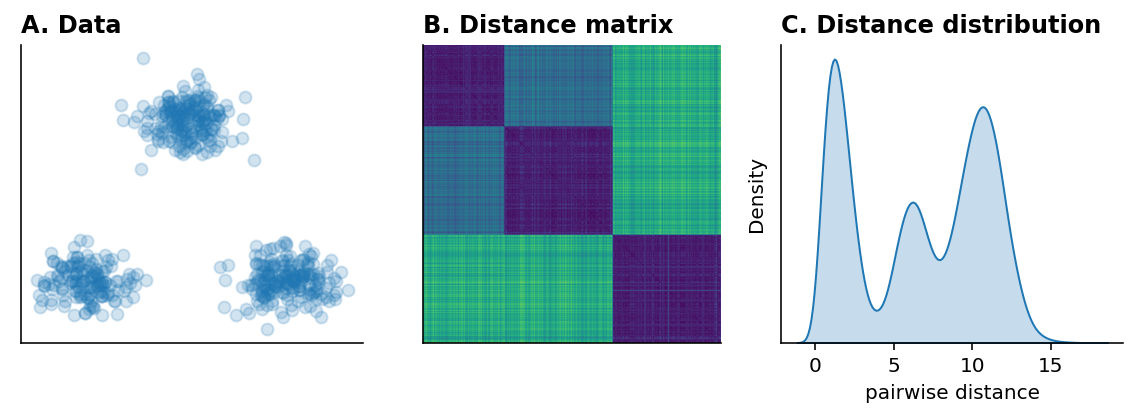

In [241]:
data = np.concatenate([
    np.random.multivariate_normal([0, 0], [[.5, 0], [0, 1]], 150), 
    np.random.multivariate_normal([6, 0], [[.5, 0], [0, 1]], 200),
    np.random.multivariate_normal([3, 10], [[.5, 0], [0, 1]], 200)
])
show_bivariate_data(data)
# plt.savefig('../figures/fig-experimental-setup/dist-dip-illustration.pdf')

In [5]:
def illustrate_dip_statistic(idxs, cdf, left, right, dip, ax=None):
    if ax is None: ax = plt.gca()
    plt.sca(ax)

    L = len(left) - 1
    R = len(idxs) - len(right)
    xL = idxs[L]
    xR = idxs[R]

    plt.plot(idxs, cdf, 'k--', label='cdf', lw=.5)
    plt.plot(idxs[:R], cdf[:R]+dip, '0.5', lw=0.5, label='cdf $F \pm d$')
    plt.fill_between(idxs, cdf+dip, cdf-dip, color='0.5', alpha=.05,)
    plt.plot(idxs[L:], cdf[L:]-dip, '0.5', lw=0.5)

    plt.plot(idxs[:L+1], left + dip, '-', lw=1, 
        label='$G$, convex part')
    plt.plot([xL, xR], [left[-1] + dip, right[0] - dip], '-', lw=1, 
        label='$G$, modal interval')
    plt.plot(idxs[R:], right - dip, '-', lw=1, 
        label='$G$, concave part')

    plt.axvline(idxs[L], c='k', ls=':', lw=.5)
    plt.axvline(idxs[R], c='k', ls=':', lw=.5)

    plt.annotate('$x_L$', xy=(idxs[L], 1.1), ha='center', va='bottom', backgroundcolor='w')
    plt.annotate('$x_R$', xy=(idxs[R], 1.1), ha='center', va='bottom', backgroundcolor='w')

    plt.legend()

# plt.figure(figsize=cm2inch(10, 6))
# dip, (cdf, idxs, left, left_part, right, right_part) = dip_fn(dataset)
# illustrate_dip_statistic(idxs, cdf, left, right, dip)

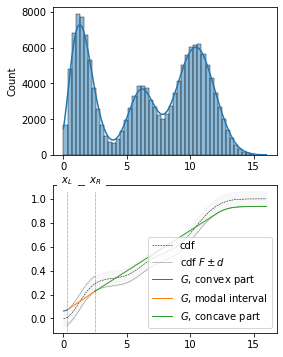

In [8]:
dists = pdist(data, metric='euclidean')
dip, (cdf, idxs, left, left_part, right, right_part) = dip_fn(dists)

fig, axs = plt.subplots(2, figsize=(4, 6))
sns.histplot(dists, ax=axs[0], bins=50, kde=True)
dip, (cdf, idxs, left, left_part, right, right_part) = dip_fn(dists)
illustrate_dip_statistic(idxs, cdf, left, right, dip, ax=axs[1])

## Visual comparison with UMAP dip test

In [21]:
X, y = datasets.load_wine(return_X_y=True)

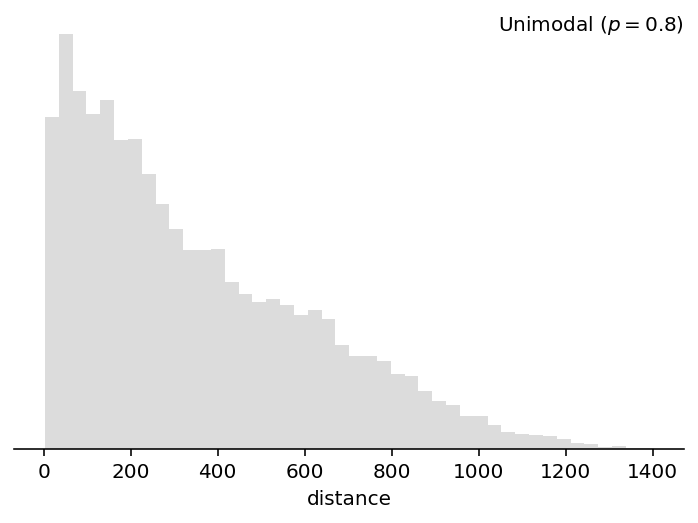

In [69]:
def show_distance_distribution(
        distances, alpha=0.05, ax=None, 
        uni_fmt='Unimodal ($p={}$)', 
        multi_fmt='Multimodal ($p={}$)', text_kws={}
    ):
    _text_kws = dict(xy=(1, 1), xycoords='axes fraction', ha='right', va='top')
    _text_kws.update(text_kws)

    if ax is None: ax = plt.gca()
    cmap = get_pval_cmap(min_gray=0.15, vmin=1e-5)
    norm = LogNorm(vmin=1e-5, vmax=1)
    dip, pval = diptest.diptest(distances)
    sns.histplot(distances, lw=0, color=cmap(norm(pval + 1e-8)), ax=ax)
    
    fmt = multi_fmt if pval < alpha else uni_fmt
    result = fmt.format(format_pval(pval))
    ax.annotate(result, **_text_kws)

    ax.set_ylabel('')
    ax.set_xlabel('distance')
    ax.set_yticks([])
    sns.despine(left=True, ax=ax)

#show_distance_distribution(pdist(X))

In [48]:
def show_embeddings(X, labels=None, ax=None, name=''):
    if ax is None: ax = plt.gca()
    if labels is not None:
        colors = [f'C{c}' for c in labels]
    else:
        colors=None
    ax.scatter(X[:, 0], X[:, 1], c=colors, s=6)
    ax.annotate(name, 
        xy=(0, 1), xycoords='axes fraction', 
        xytext=(5, -5), textcoords='offset points',
        ha='left', va='top', fontsize=11, color='0.5')
    ax.set_yticks([])
    ax.set_xticks([])

In [49]:
def show_umap_dist_test(X, labels=None, **umap_kws):
    dim = min(5, X.shape[1])
    _umap_kws = dict(min_dist=0, n_neighbors=50, random_state=1, n_components=dim)
    _umap_kws.update(umap_kws)
    fig, axs = plt.subplots(2, 2, gridspec_kw=dict(height_ratios=[3,1]), figsize=(8, 5), tight_layout=True)

    title('A. Dist-dip test', ax=axs[0, 0])
    X_pca = PCA(n_components=2).fit_transform(X)
    show_embeddings(X_pca, labels, ax=axs[0, 0], name='PCA')
    show_distance_distribution(pdist(X), ax=axs[1, 0])
    axs[0,0].set_ylabel('Visualization', fontweight='bold')

    title('B. UMAP-dip test', ax=axs[0, 1])
    axs[1, 0].set_ylabel('Distance\ndistribution', fontweight='bold')
    X_umap = umap.UMAP().fit_transform(X)
    show_embeddings(X_umap, labels, ax=axs[0, 1], name='2d UMAP')
    if dim == 2:
        dists = pdist(X_umap)
    else:
        dists = pdist(umap.UMAP(**_umap_kws).fit_transform(X))
    show_distance_distribution(dists, ax=axs[1, 1])

# show_umap_dist_test(X, y)

### Synthetic datasets

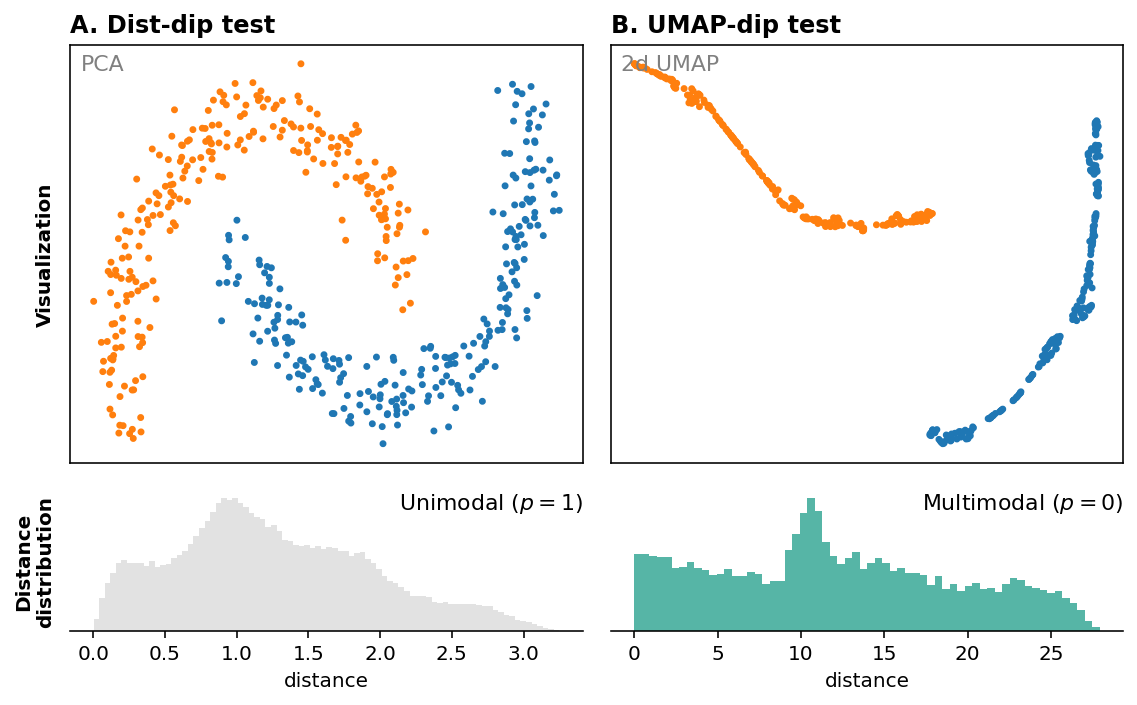

In [50]:
X, y = datasets.make_moons(n_samples=500, noise=.1)
show_umap_dist_test(X, y)

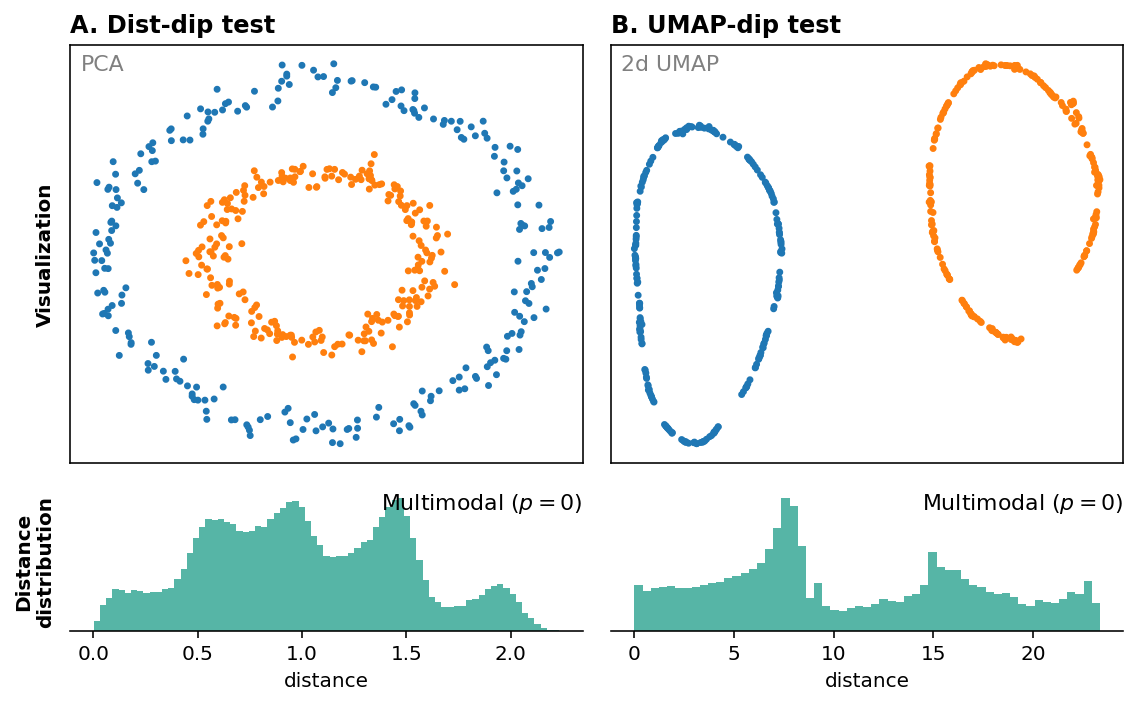

In [51]:
X, y = datasets.make_circles(n_samples=500, noise=0.05, factor=0.5)
show_umap_dist_test(X, y)

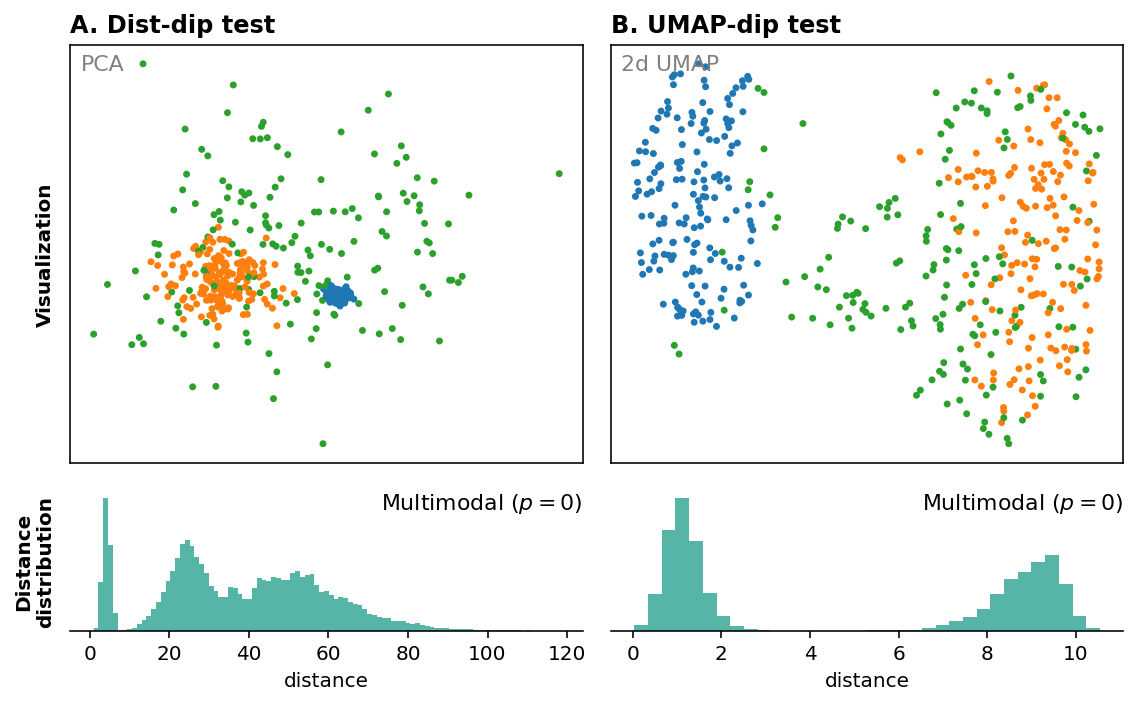

In [52]:
X, y = datasets.make_blobs(n_samples=500, n_features=10, cluster_std=[1, 5, 15], random_state=0)
show_umap_dist_test(X, y)

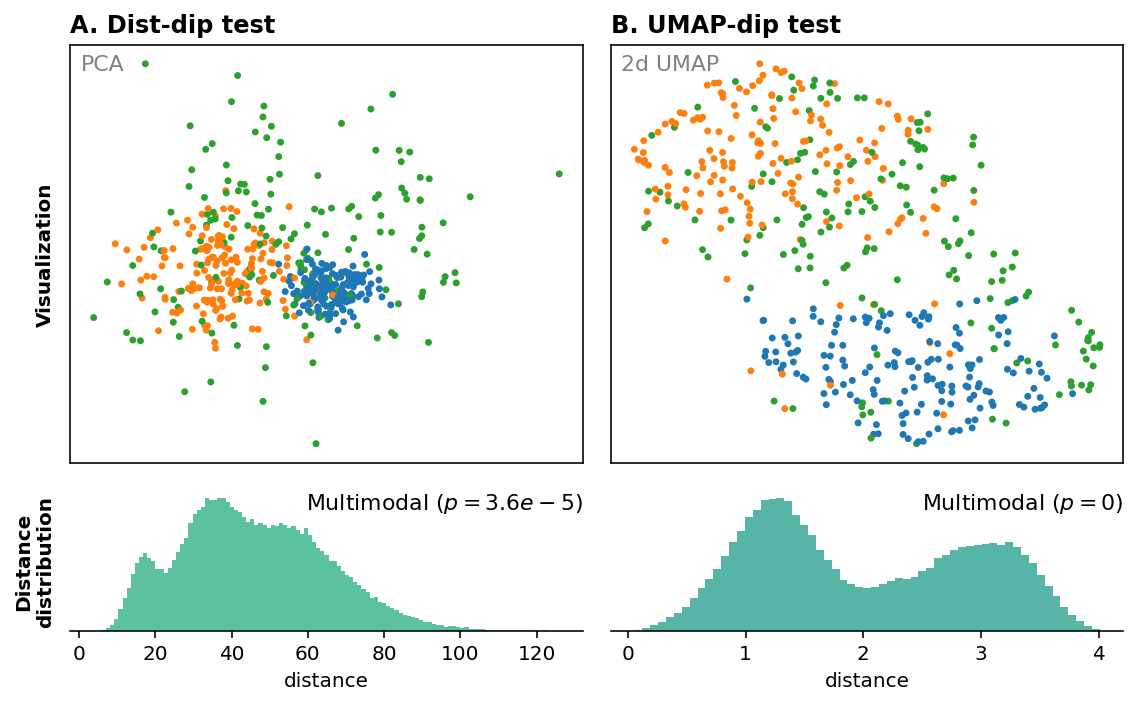

In [53]:
X, y = datasets.make_blobs(n_samples=500, n_features=10, cluster_std=[4, 8, 16], random_state=0)
show_umap_dist_test(X, y)

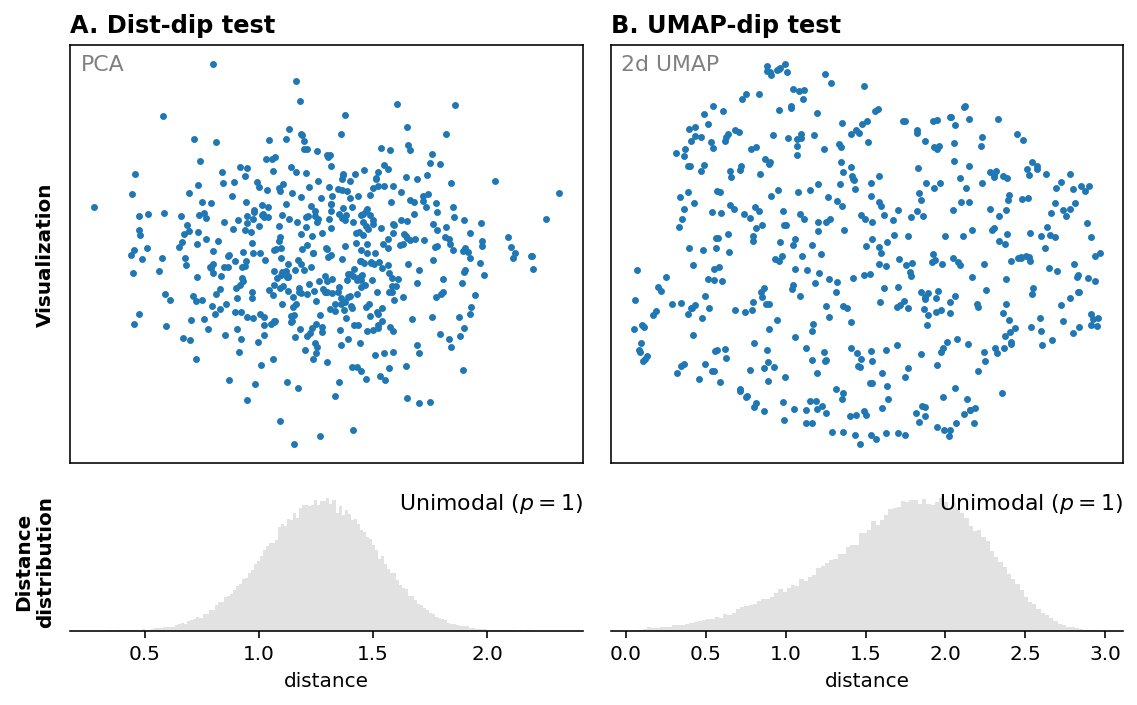

In [54]:
X = np.random.rand(500, 10)
show_umap_dist_test(X)

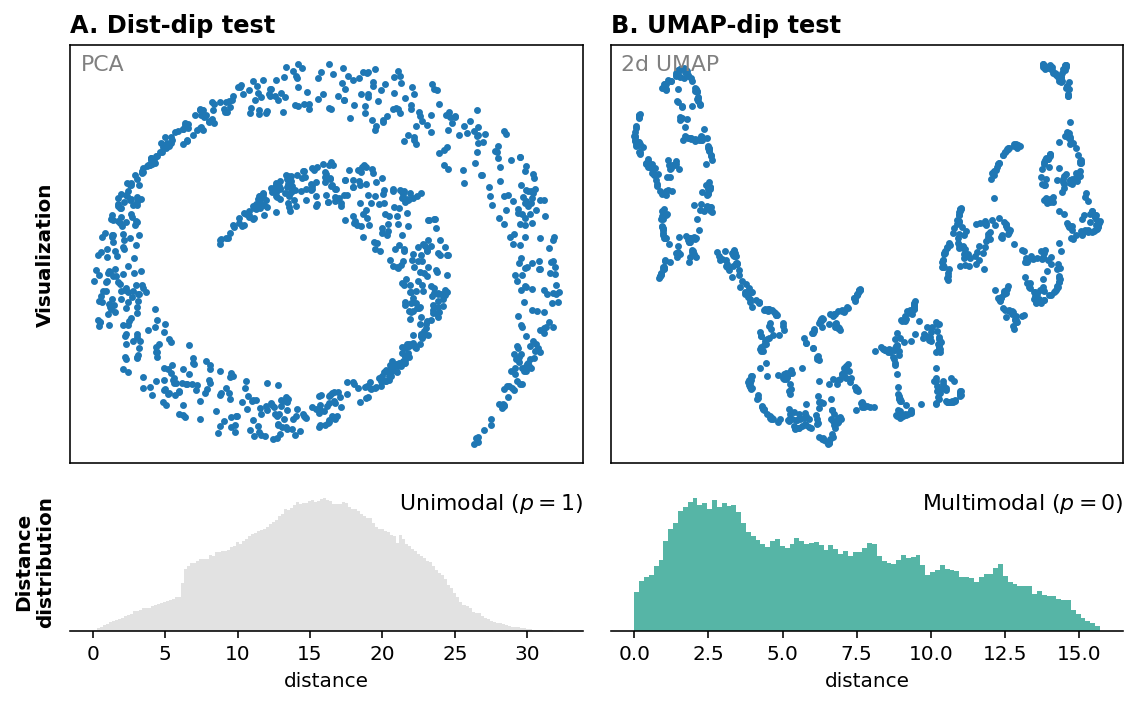

In [55]:
X, _ = datasets.make_swiss_roll(n_samples=1000, noise=0.1)
show_umap_dist_test(X, n_neighbors=50)

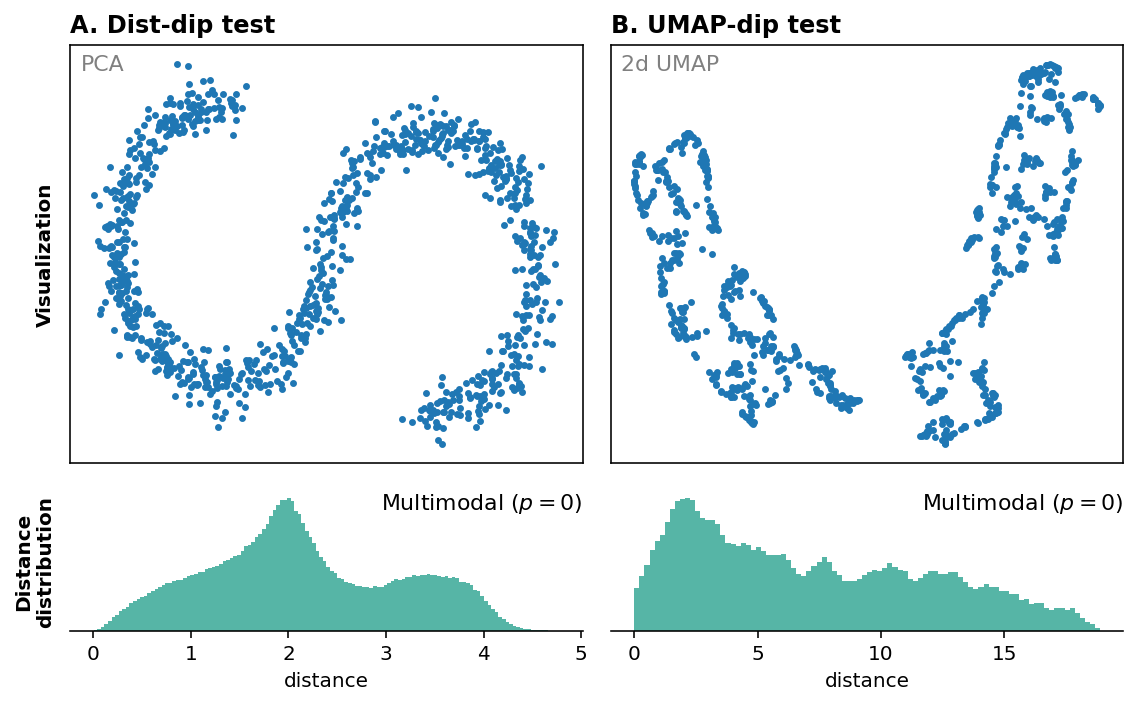

In [56]:
X, _ = datasets.make_s_curve(n_samples=1000, noise=0.1)
show_umap_dist_test(X)

### Real datasets

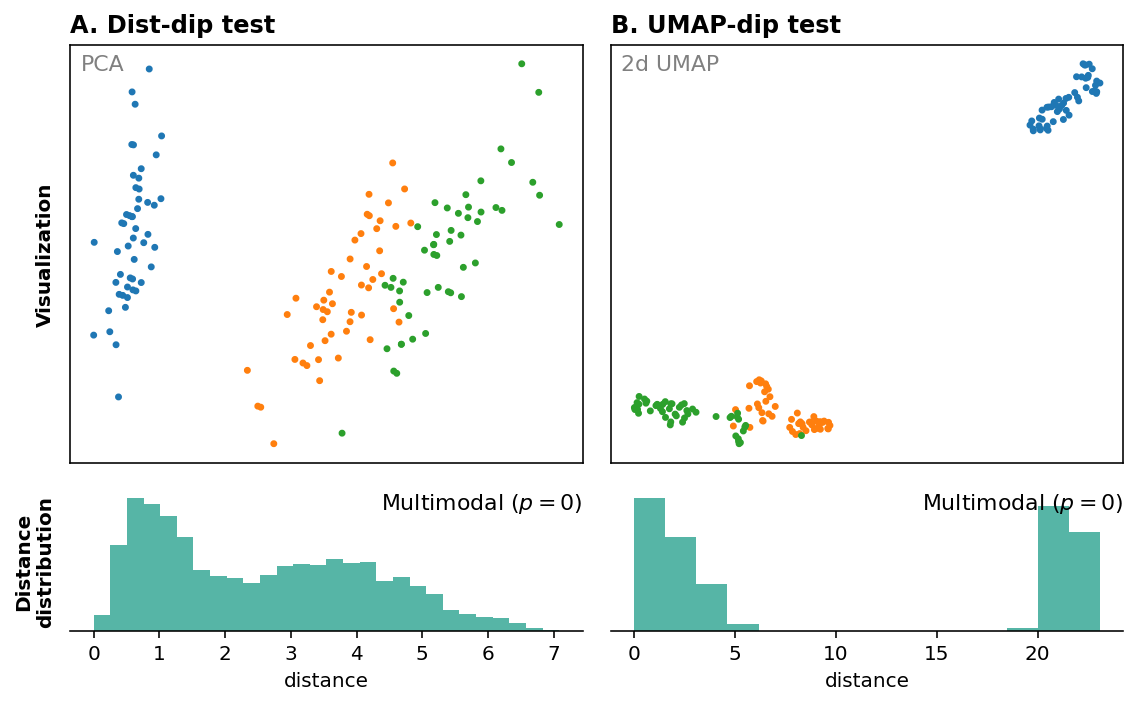

In [58]:
X, y = datasets.load_iris(return_X_y=True)
show_umap_dist_test(X, y)

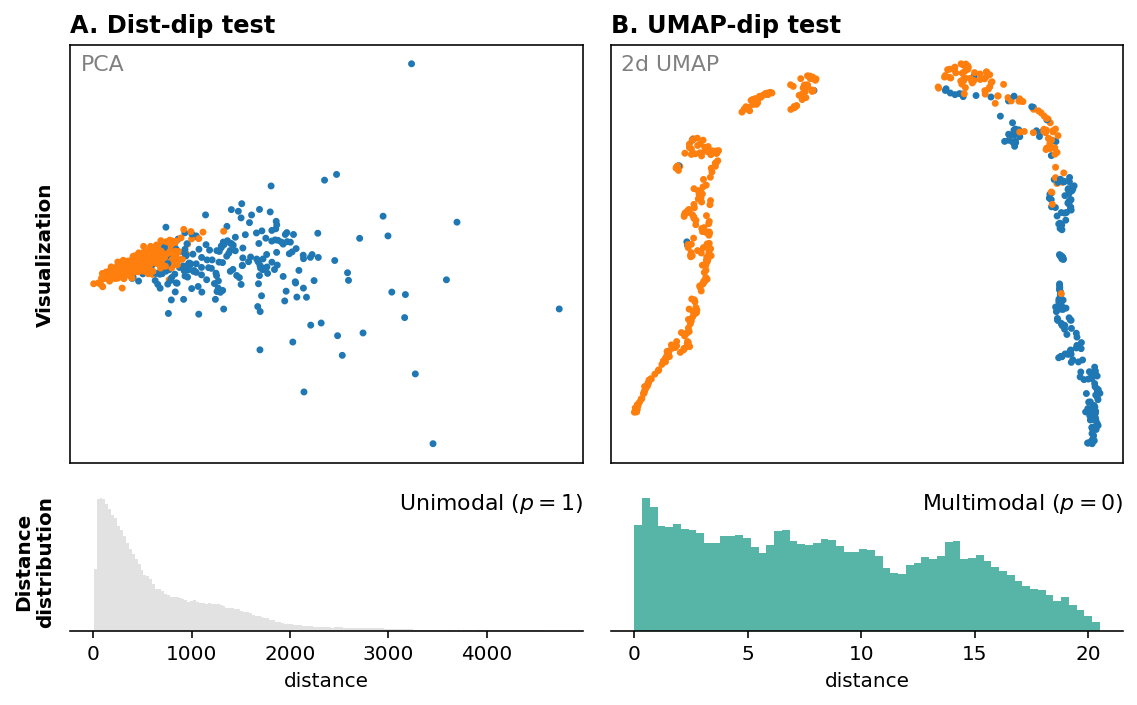

In [59]:
X, y = datasets.load_breast_cancer(return_X_y=True)
show_umap_dist_test(X, y)

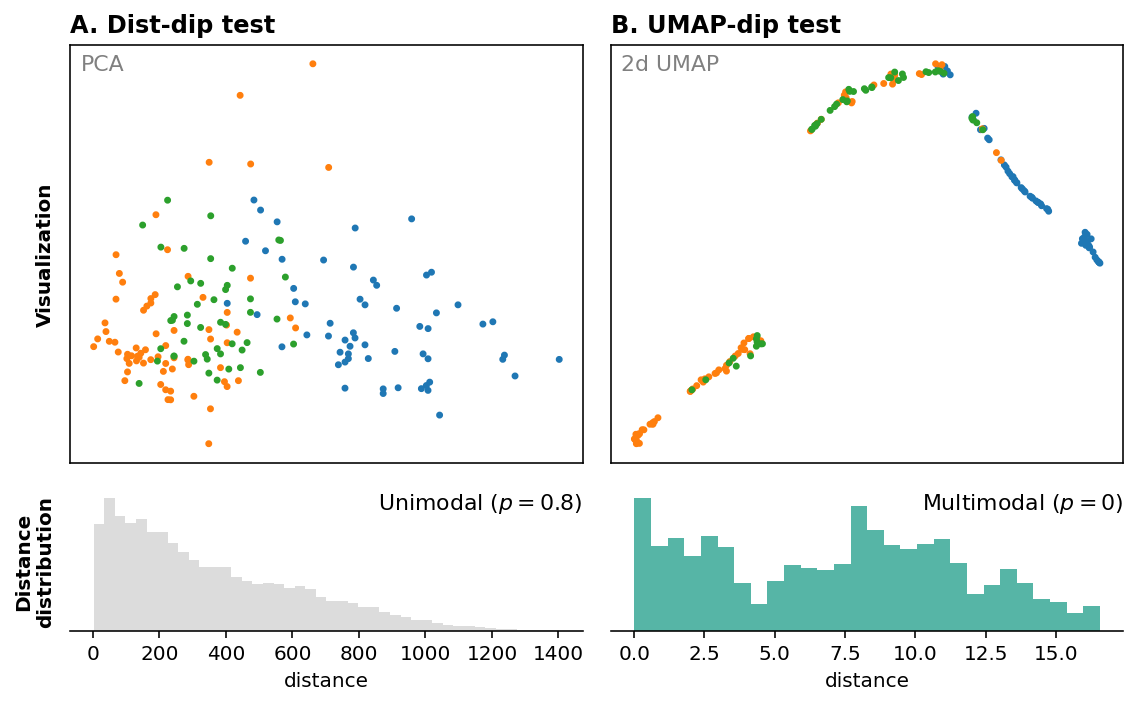

In [60]:
X, y = datasets.load_wine(return_X_y=True)
show_umap_dist_test(X, y, n_neighbors=50, n_components=3)

## Distinguish clustered from unclustered synthetic contours?

In [124]:
def compare_dims_metrics(
        dataset, 
        representation='pitch_centered',
        dims = [10, 50], 
        metrics = ['euclidean', 'chebyshev', 'correlation', 'dtw', 'umap'],
        alpha=0.05,
        axs=None,
        show_titles=True,
    ):

    if axs is None:
        fig, axs = plt.subplots(len(dims), len(metrics), sharex='col',
            tight_layout=True, figsize=(len(metrics)*1.75, len(dims) * 1))

    for i, dim in enumerate(dims):
        condition = Condition(dataset, representation, 'eucl', limit=200, dimensionality=dim)

        for j, metric in enumerate(metrics):
            if metric == 'dtw':
                distances = squareform(cdist_dtw(condition.contours()))
            elif metric == 'umap':
                distances = pdist(condition.umap_embeddings(refresh_serialized=True))
            elif metric == 'pca':
                pca = PCA(n_components=min(10, dim))
                distances = pdist(pca.fit_transform(condition.contours()))
            else:    
                props = dict(metric=metric)
                if metric == 'minkowski': props['p'] = 1
                distances = pdist(condition.contours(), **props)
            
            ax = axs[i, j]
            show_distance_distribution(
                distances, alpha=alpha, ax=ax,
                uni_fmt='$p={}$', multi_fmt='$p={}$',
                text_kws=dict(ha='center', xy=(.5, .5))
            )

            if i == 0 and show_titles:
                title(metric, x=0, ha='left', ax=ax)
            if j == 0:
                ax.set_ylabel(f'dim={dim}', ha='right', va='center', rotation=0, fontsize=12)
                ax.set_yticks([])
            else:
                ax.set_yticks([])
                ax.set_ylabel('')

# compare_dims_metrics('clustered')


Text(0, 0.5, 'Clustered')

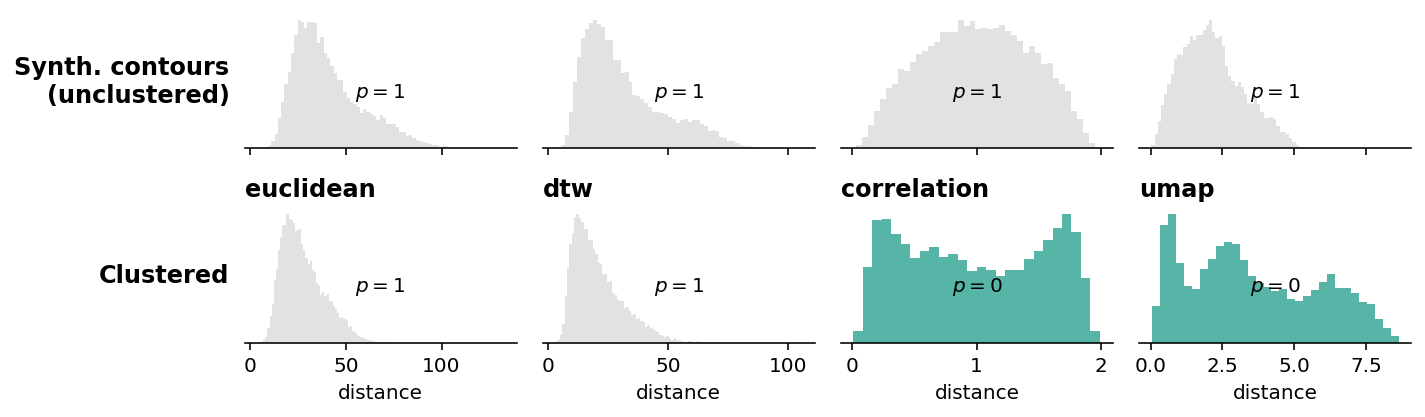

In [128]:
dims = [50, ]
metrics = ['euclidean', 'dtw', 'correlation', 'umap']

fig, axs = plt.subplots(
    len(dims) * 2, 
    len(metrics), 
    sharex='col', tight_layout=True, 
    figsize=(10, 3)
)
compare_dims_metrics('markov', axs=axs[:1, :], dims=dims, metrics=metrics, show_titles=False)
compare_dims_metrics('clustered', axs=axs[1:, :], dims=dims, metrics=metrics)
axs[0, 0].set_ylabel('Synth. contours\n(unclustered)', ha='right', fontweight='bold')
axs[1, 0].set_ylabel('Clustered', ha='right', fontweight='bold')

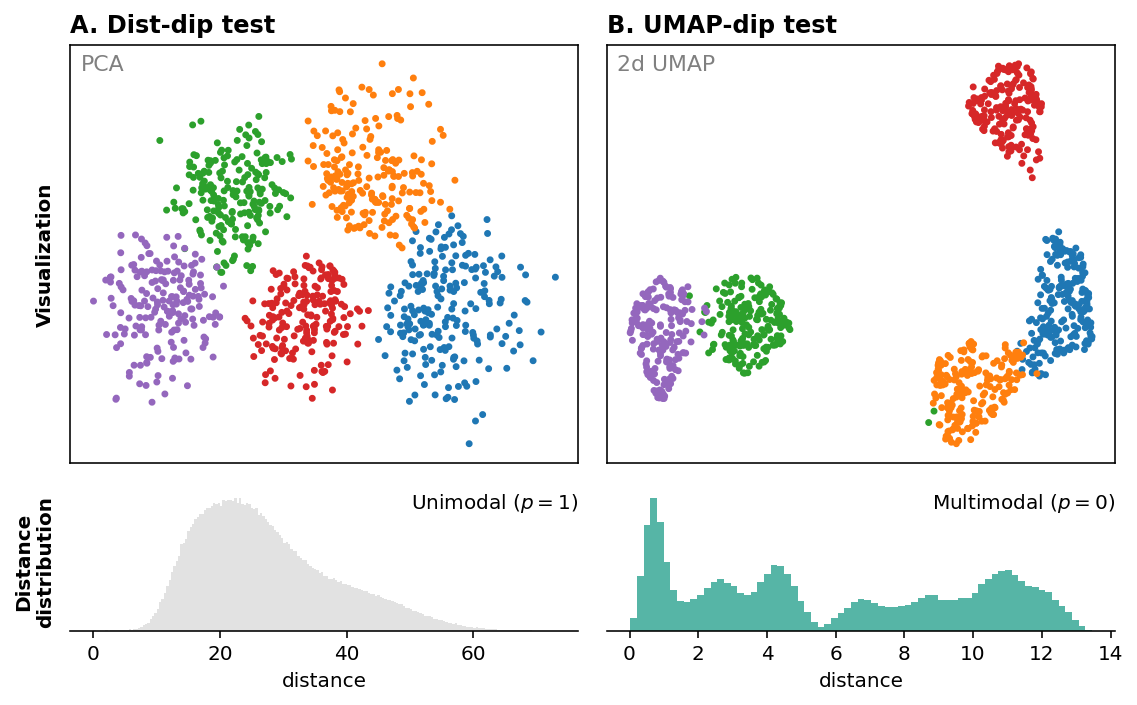

In [136]:
condition = Condition('clustered', 'pitch_centered', 'eucl', limit=1000, dimensionality=50)
show_umap_dist_test(condition.contours(), labels=condition.df['label'])

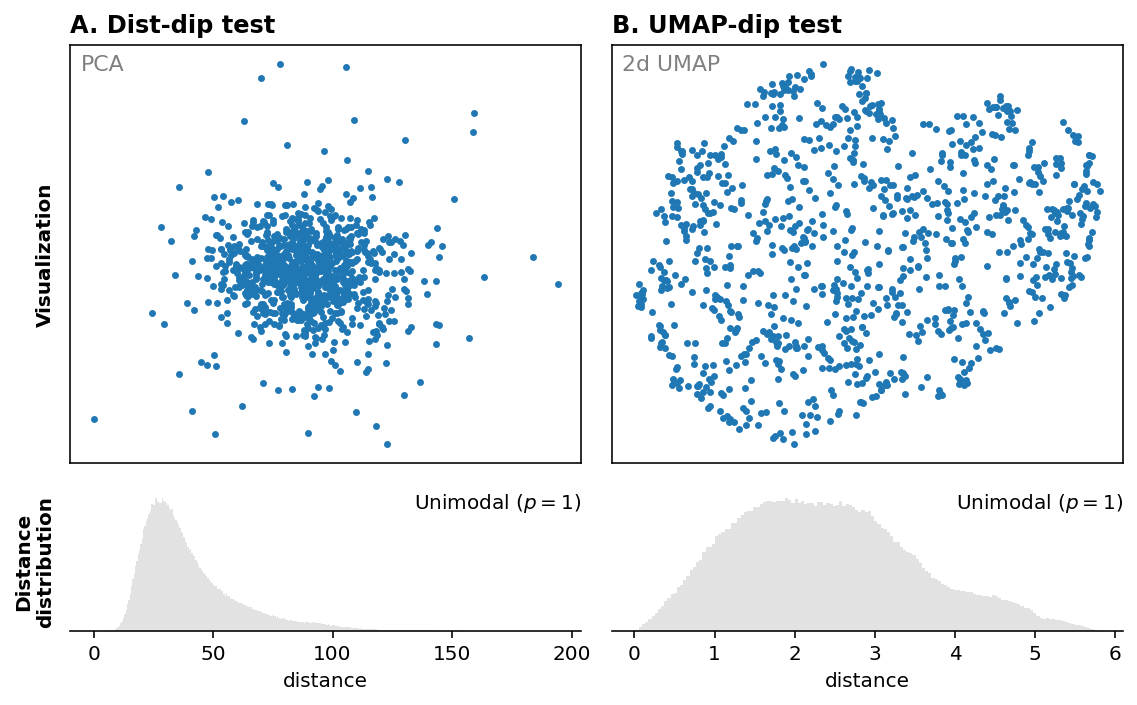

In [138]:
condition = Condition('markov', 'pitch_centered', 'eucl', limit=1000, dimensionality=50)
show_umap_dist_test(condition.contours())